In [1]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
def load_data(file_path):
    return pd.read_json(file_path, lines=True)

In [3]:
def add_features(df):
    df['length_of_sentence'] = df['text'].apply(len)
    df['lexicon_density'] = df['text'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
    df['type_token_ratio'] = df['text'].apply(lambda tokens: len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0)
    word_counts = Counter()
    df['text'].apply(word_counts.update)
    rare_words = {word for word, freq in word_counts.items() if freq <= 5}
    df['rare_word_count'] = df['text'].apply(lambda tokens: sum(1 for token in tokens if token in rare_words))
    return df, rare_words


In [4]:
def initialize_and_save_tools(df):
    # Assuming 'text_str' for vectorization purposes only, not for scaling
    df['text_str'] = df['text'].apply(lambda tokens: ' '.join(map(str, tokens)))

    # Initialize and fit vectorizers
    count_vectorizer = CountVectorizer(max_features=5000)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    count_vectorizer.fit(df['text_str'])
    tfidf_vectorizer.fit(df['text_str'])

    # Initialize and fit scaler
    scaler = MinMaxScaler()
    # Ensure the feature set here matches the one used in transformations
    scaler.fit(df[['length_of_sentence', 'lexicon_density', 'rare_word_count', 'type_token_ratio']])

    return scaler, count_vectorizer, tfidf_vectorizer

In [5]:
def preprocess_and_feature_engineer(df, scaler, count_vectorizer, tfidf_vectorizer):
    # Ensure 'id' is not included in any feature processing
    if 'id' in df.columns:
        df_features = df.drop(columns=['id'])
    else:
        df_features = df.copy()  # Work on a copy to avoid modifying the original DataFrame
    
    # Prepare text strings for vectorization
    df_features['text_str'] = df_features['text'].apply(lambda tokens: ' '.join(map(str, tokens)))
    
    # Vectorize text
    count_features = count_vectorizer.transform(df_features['text_str']).toarray()
    tfidf_features = tfidf_vectorizer.transform(df_features['text_str']).toarray()
    
    # Ensure the scaler is applied to the correct columns
    additional_features = scaler.transform(df_features[['length_of_sentence', 'lexicon_density', 'rare_word_count', 'type_token_ratio']])
    
    # Combine all features into a single array
    return np.hstack([count_features, tfidf_features, additional_features])


In [6]:
def add_features_specific(df, rare_words):
    df['length_of_sentence'] = df['text'].apply(len)
    df['type_token_ratio'] = df['text'].apply(lambda tokens: len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0)
    df['lexicon_density'] = df['type_token_ratio']  # or any specific definition
    df['rare_word_count'] = df['text'].apply(lambda tokens: sum(1 for token in tokens if token in rare_words))
    return df

In [7]:
# Load datasets
df_domain1 = load_data('domain1_train_data.json')
df_domain2 = load_data('domain2_train_data.json')
df_test = load_data('test_data.json')

In [8]:
# Combine and initialize tools on training data only
df_train = pd.concat([df_domain1, df_domain2], ignore_index=True)
df_train, rare_words = add_features(df_train)
scaler, count_vectorizer, tfidf_vectorizer = initialize_and_save_tools(df_train)


In [9]:
# Add features to each dataset separately
df_domain1 = add_features_specific(df_domain1, rare_words)
df_domain2 = add_features_specific(df_domain2, rare_words)
df_test = add_features_specific(df_test, rare_words)


In [10]:
# Preprocess each dataset
features_domain1 = preprocess_and_feature_engineer(df_domain1, scaler, count_vectorizer, tfidf_vectorizer)
features_domain2 = preprocess_and_feature_engineer(df_domain2, scaler, count_vectorizer, tfidf_vectorizer)
features_test = preprocess_and_feature_engineer(df_test, scaler, count_vectorizer, tfidf_vectorizer)

In [11]:
print(df_domain1.head(1))
print(df_domain1.tail(1))
print(features_domain1[0])
print(features_domain1[-1])


                                                text  label  id  \
0  [16, 231, 543, 5, 15, 43, 8282, 94, 231, 1129,...      1   0   

   length_of_sentence  type_token_ratio  lexicon_density  rare_word_count  
0                  39          0.666667         0.666667                0  
                                                   text  label    id  \
4999  [15, 25, 12264, 20611, 29, 25, 2, 1673, 900, 2...      0  4999   

      length_of_sentence  type_token_ratio  lexicon_density  rare_word_count  
4999                 148          0.655405         0.655405                2  
[0.         0.         0.         ... 0.66171702 0.         0.66171702]
[1.         0.         0.         ... 0.65028854 0.00628931 0.65028854]


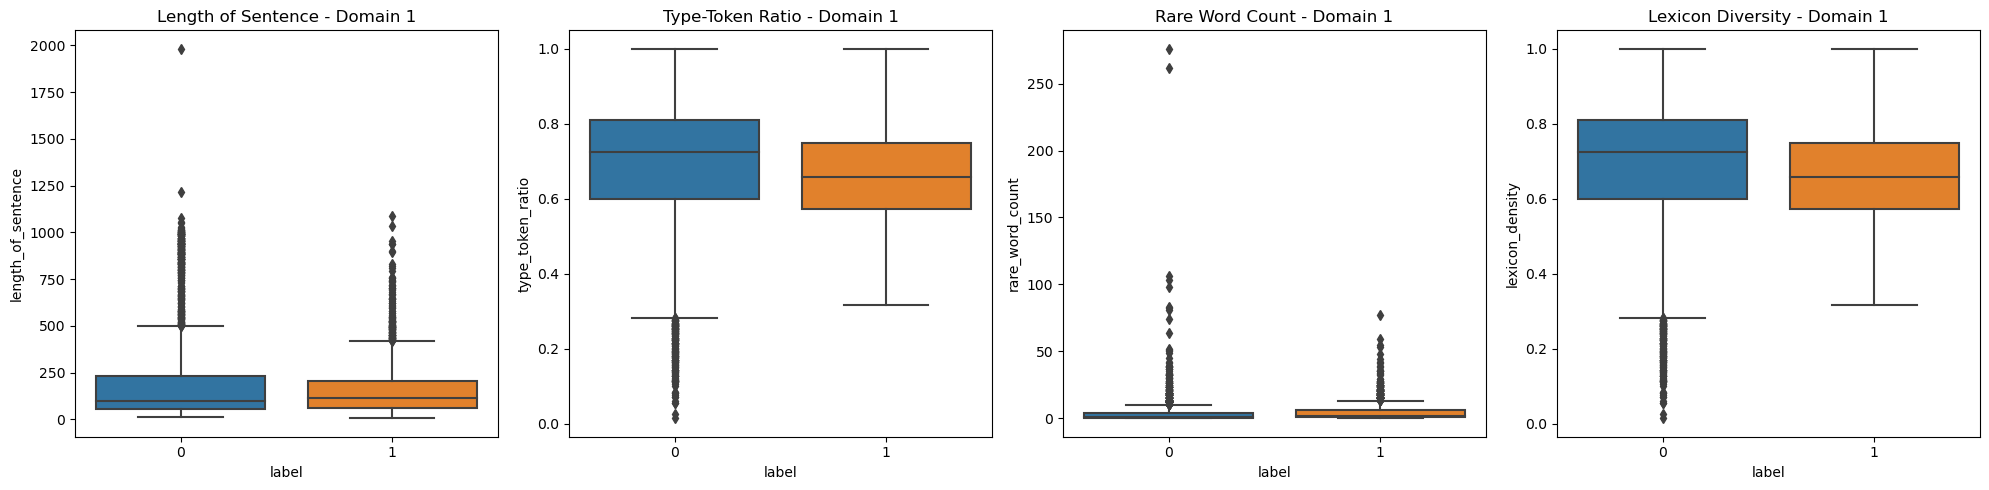

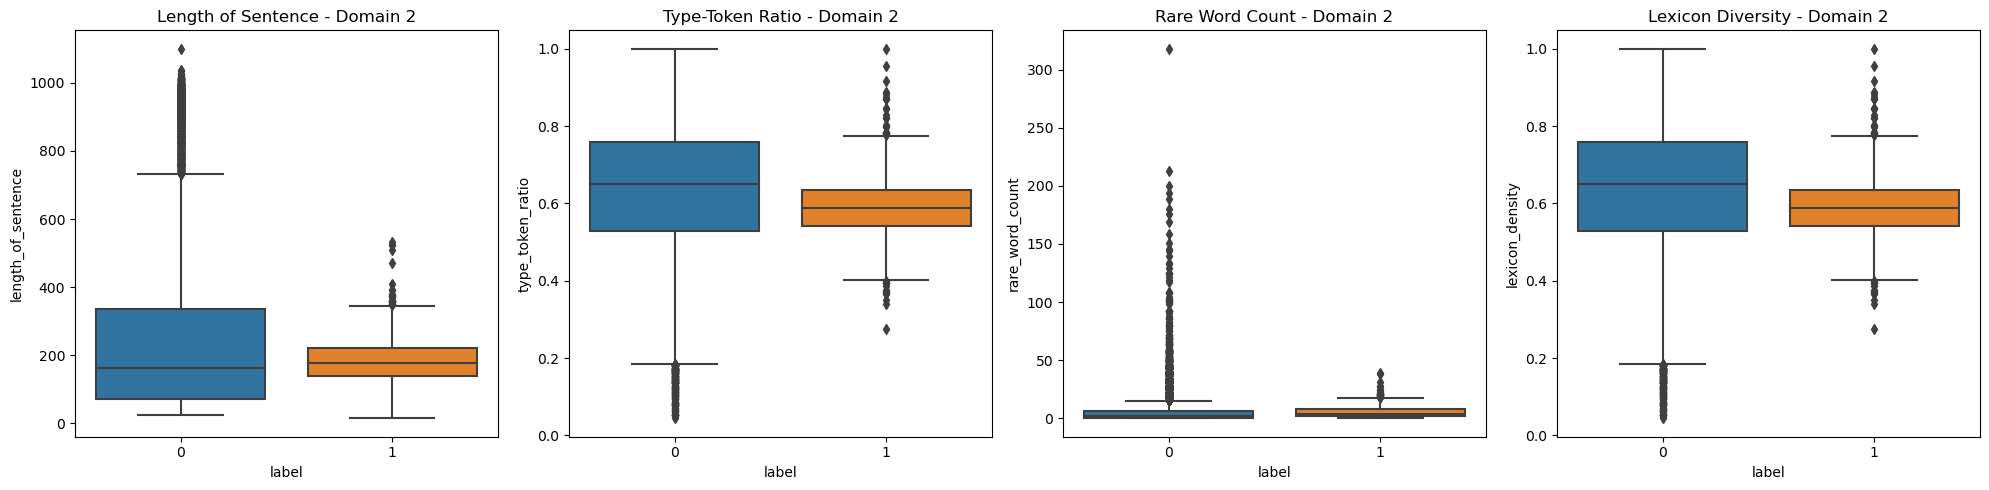

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_features(df, title):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    sns.boxplot(x='label', y='length_of_sentence', data=df)
    plt.title('Length of Sentence - ' + title)

    plt.subplot(1, 4, 2)
    sns.boxplot(x='label', y='type_token_ratio', data=df)
    plt.title('Type-Token Ratio - ' + title)

    plt.subplot(1, 4, 3)
    sns.boxplot(x='label', y='rare_word_count', data=df)
    plt.title('Rare Word Count - ' + title)

    plt.subplot(1, 4, 4)
    sns.boxplot(x='label', y='lexicon_density', data=df)
    plt.title('Lexicon Diversity - ' + title)

    plt.tight_layout()
    plt.show()

# Assume df_domain1 and df_domain2 are already processed with add_features
plot_features(df_domain1, 'Domain 1')
plot_features(df_domain2, 'Domain 2')


In [13]:
# Split the data for Domain 1
X_train_domain1, X_val_domain1, y_train_domain1, y_val_domain1 = train_test_split(
    features_domain1, df_domain1['label'], test_size=0.2, random_state=42)

# Split the data for Domain 2
X_train_domain2, X_val_domain2, y_train_domain2, y_val_domain2 = train_test_split(
    features_domain2, df_domain2['label'], test_size=0.2, random_state=42)

# Initialize the RandomUnderSampler
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)

# Resample the Domains
X_train_domain1_resampled, y_train_domain1_resampled = smote.fit_resample(X_train_domain1, y_train_domain1)
X_train_domain2_resampled, y_train_domain2_resampled = rus.fit_resample(X_train_domain2, y_train_domain2)
X_val_domain1_resampled, y_val_domain1_resampled = smote.fit_resample(X_val_domain1, y_val_domain1)
X_val_domain2_resampled,y_val_domain2_resampled = rus.fit_resample(X_val_domain2, y_val_domain2)


# Combine datasets from Domain 1 and Domain 2
X_train_combined = np.vstack((X_train_domain1_resampled, X_train_domain2_resampled))
y_train_combined = np.concatenate((y_train_domain1_resampled, y_train_domain2_resampled))
X_val_combined = np.vstack((X_val_domain1_resampled, X_val_domain2_resampled))
y_val_combined = np.concatenate((y_val_domain1_resampled, y_val_domain2_resampled))

In [14]:
### 

In [17]:
# Combine domain1 and domain2 for training
df_combined = pd.concat([df_domain1, df_domain2], ignore_index=True)
df_combined, rare_words = add_features(df_combined)
df_combined = add_features_specific(df_combined, rare_words)  # Update feature engineering function if needed

# Apply specific feature engineering to each dataset
df_domain1 = add_features_specific(df_domain1, rare_words)
df_domain2 = add_features_specific(df_domain2, rare_words)
df_test = add_features_specific(df_test, rare_words)  # Apply to test data as well

# Initialize and fit preprocessors on the combined dataset
scaler, count_vectorizer, tfidf_vectorizer = initialize_and_save_tools(df_combined)

# Preprocess the combined dataset
features_combined = preprocess_and_feature_engineer(df_combined, scaler, count_vectorizer, tfidf_vectorizer)
labels_combined = pd.concat([df_domain1['label'], df_domain2['label']], ignore_index=True)


In [18]:
X_train, X_val, y_train, y_val = train_test_split(features_combined, labels_combined, test_size=0.2, random_state=42)


In [ ]:
stacking_cls = StackingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42)),
        ('lr', LogisticRegression(random_state=42)),
        ('knn', KNeighborsClassifier())
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    cv=5
)

# Train the classifier
stacking_cls.fit(X_train, y_train)

In [ ]:
y_val_pred = stacking_cls.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

In [ ]:
df_test = add_features_specific(df_test, rare_words)
features_test = preprocess_and_feature_engineer(df_test, scaler, count_vectorizer, tfidf_vectorizer)

test_predictions = stacking_cls.predict(features_test)
# Optionally, save predictions to a file
pd.DataFrame(test_predictions, columns=['Prediction']).to_csv('test_predictions.csv', index=False)
